In [1]:
from src import *
from utils import *
import os
import os.path as osp
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import cPickle
import torch

In [2]:
config_dict = {
    'gpu': 0, 
    'resume': './logs/final_train',
#     'resume': False,
    
    'max_iteration': 1000000,
    'lr': 0.0001,
    'weight_decay': 0.00001,
    'momentum': 0.99,
    'batch_size': 6,
    'model': 'fcn8',
    'n_class': 30+1,
    'interval_validate': 10000,
}

args = DictToObject(config_dict)

# data loader

In [3]:
label_df = pd.read_csv('./train_answer.csv')


In [4]:
label_df.columns[1:args.n_class]

Index(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
       'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
       'wow', 'yes', 'zero'],
      dtype='object')

In [5]:
# data loader

# 앞에서 9만번까지는 train 그 다음은 valid로 사용
train_dir_list = np.sort(glob.glob('./train/*.wav'))[:90000]
valid_dir_list = np.sort(glob.glob('./train/*.wav'))[90000:]

train_dataset = GetTrainDataset(train_dir_list, label_df=label_df.iloc[:90000], class_list=label_df.columns[1:args.n_class]) 
valid_dataset = GetTrainDataset(valid_dir_list, label_df=label_df.iloc[900:], class_list=label_df.columns[1:args.n_class]) 

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지

# model

In [6]:
model = FCN8s(n_class=args.n_class)
start_epoch = 0
start_iteration = 0
if args.resume:
    checkpoint = torch.load(args.resume+'/checkpoint.pth.tar')
    
    # backbone 부분만 불러올려고 쓸모없는 정보는 지워버림
    # class dependancy 있는 친구들 제거
    new_model_dict = model.state_dict()
    pretrained_dict = checkpoint['model_state_dict']
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'block' in k}
    new_model_dict.update(pretrained_dict)
    
    #model.load_state_dict(checkpoint['model_state_dict'])
    model.load_state_dict(new_model_dict)
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']

model = model.cuda()


In [35]:
batch_idx, (data, target) = next(enumerate(valid_loader))

val_loss = 0
visualizations = []
label_trues, label_preds = [], []
data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target).to(dtype=torch.long) # target data type 이슈
sys.stdout.write('\r {}'.format(batch_idx))
with torch.no_grad():
    score, score_softmax = model(data)

 0

In [36]:
for i in range(31):
    if np.array(target[0, i, 0, 0].cpu()) == 1:
        print (i, label_df.columns[1:args.n_class][i-1])
        

11 house
16 off
20 seven
27 up


$$ \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$ 

In [69]:
import torch.nn.functional as F

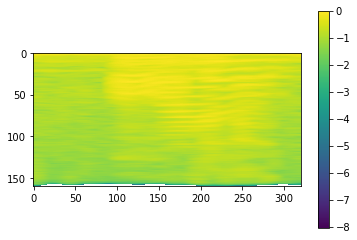

In [75]:
plt.imshow(torch.log(data[0, 0, :, :]).cpu().numpy())
plt.colorbar()
plt.show()

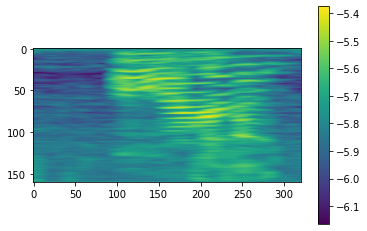

In [71]:
plt.imshow(F.log_softmax(data[0, 0, :, :], dim=1).cpu().numpy())
plt.colorbar()
plt.show()

0.08658089


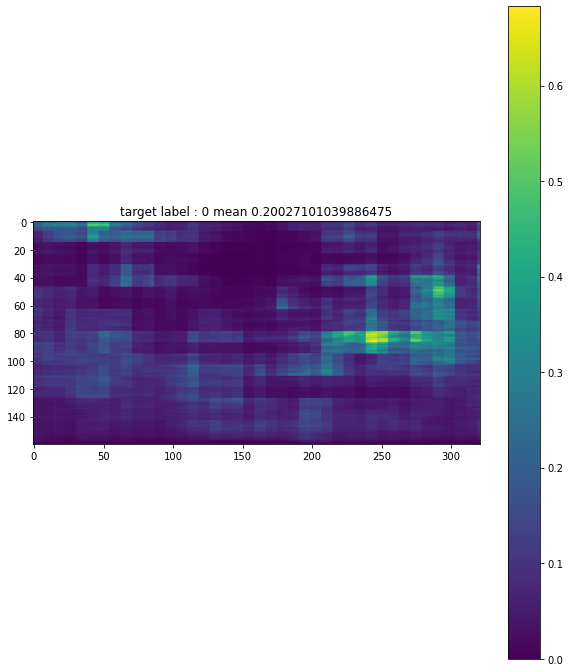

0.21852623


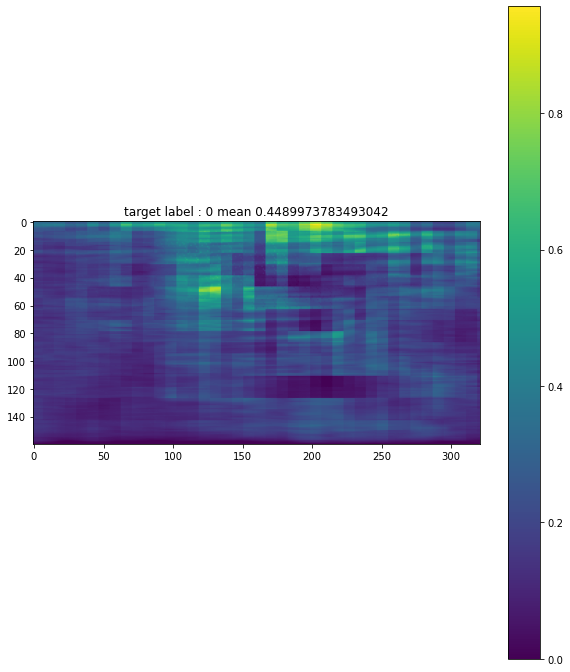

0.20211178


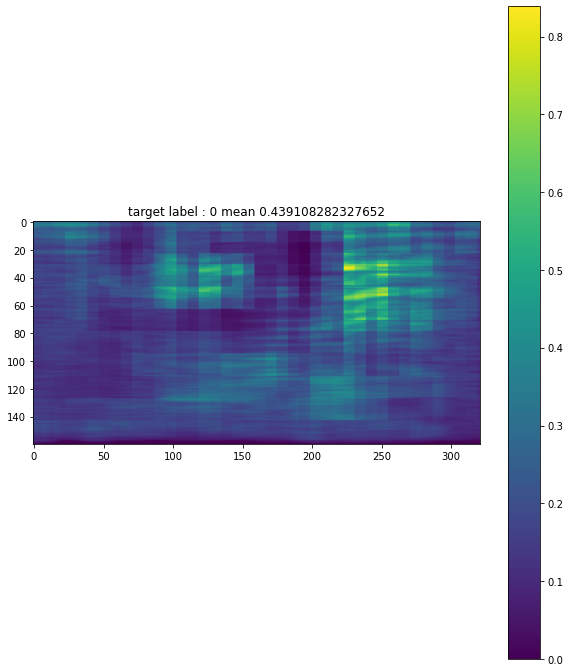

0.13824472


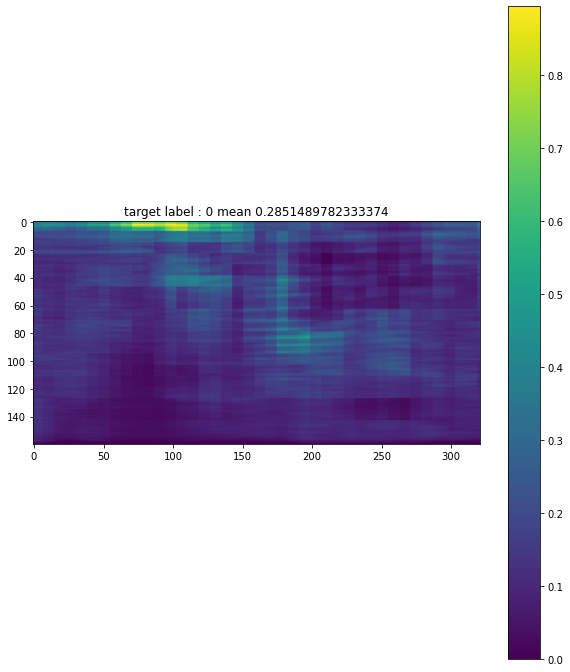

0.21327114


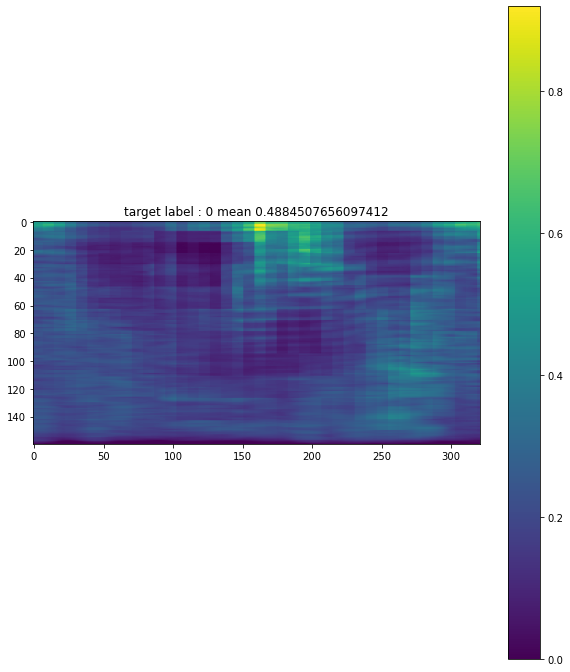

0.22467075


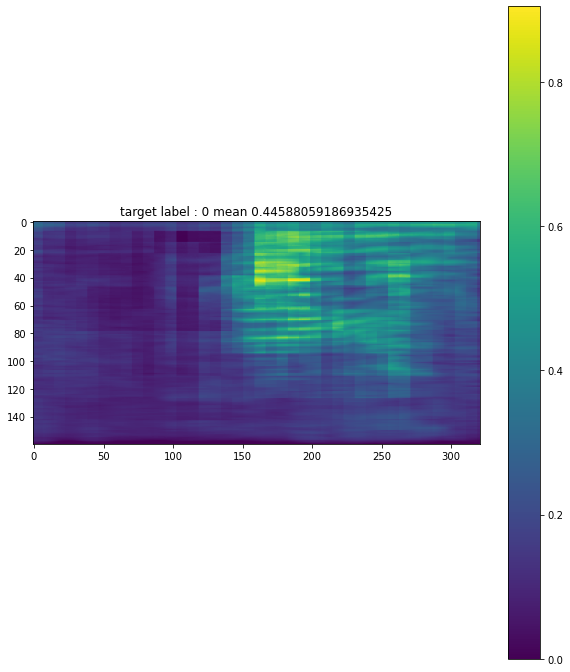

0.19479062


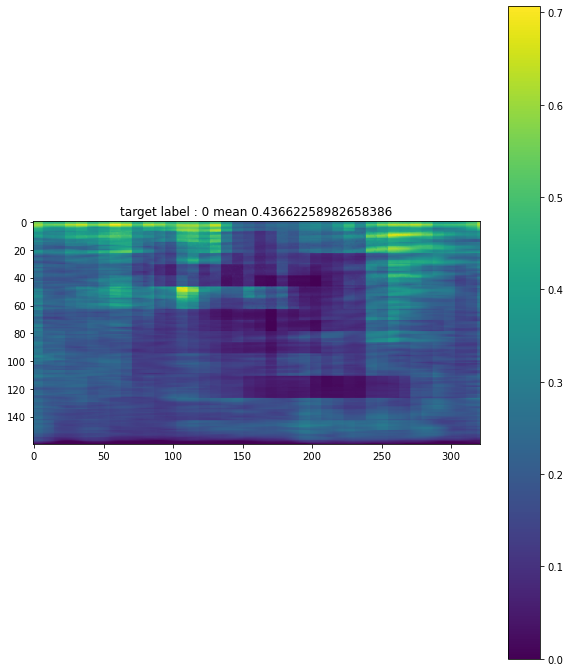

0.21455789


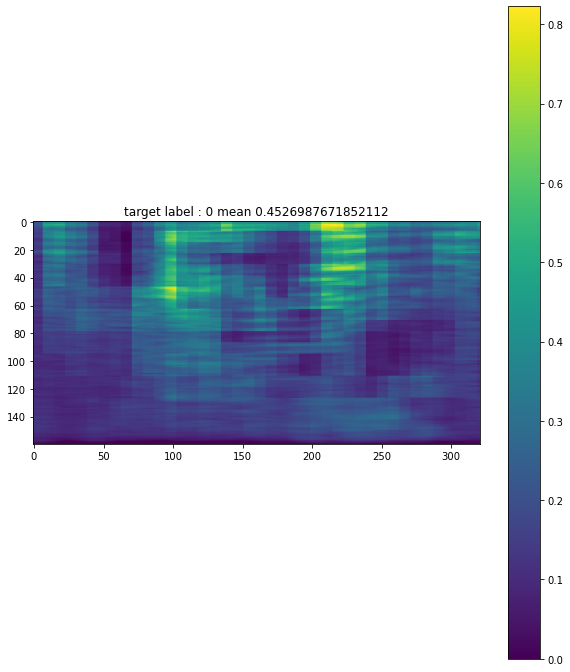

0.1594087


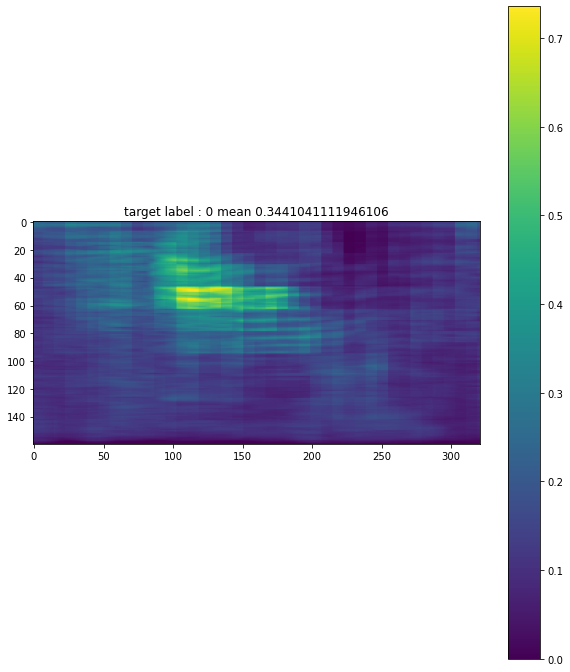

0.25754738


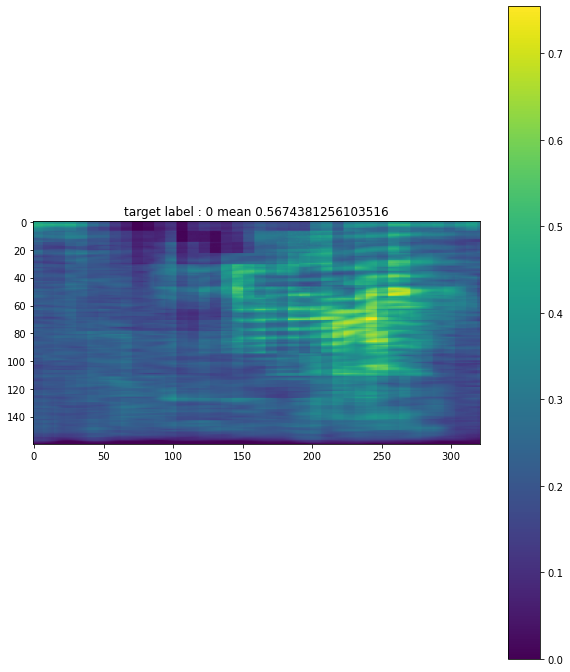

0.17137526


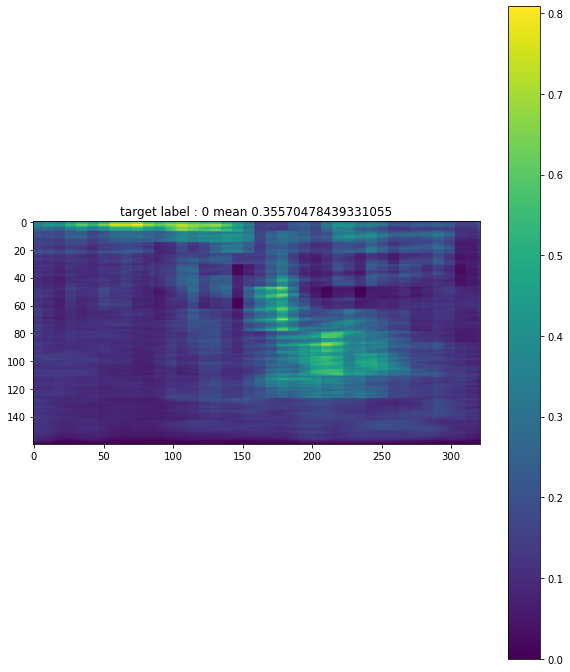

0.16411553


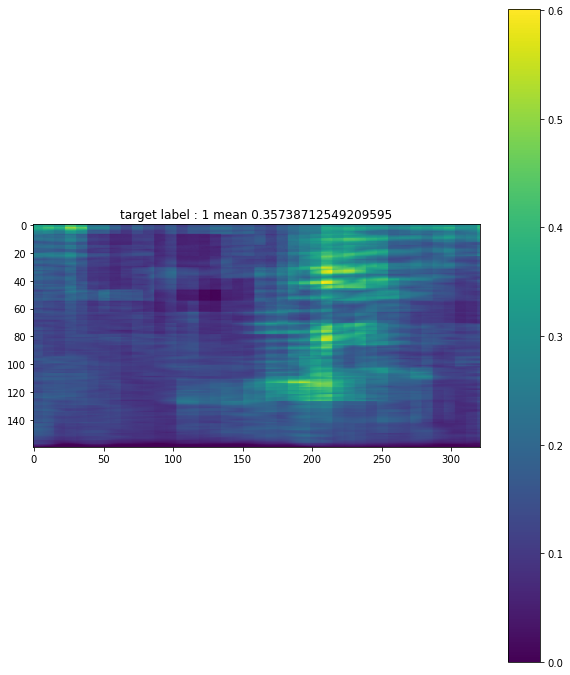

0.15445144


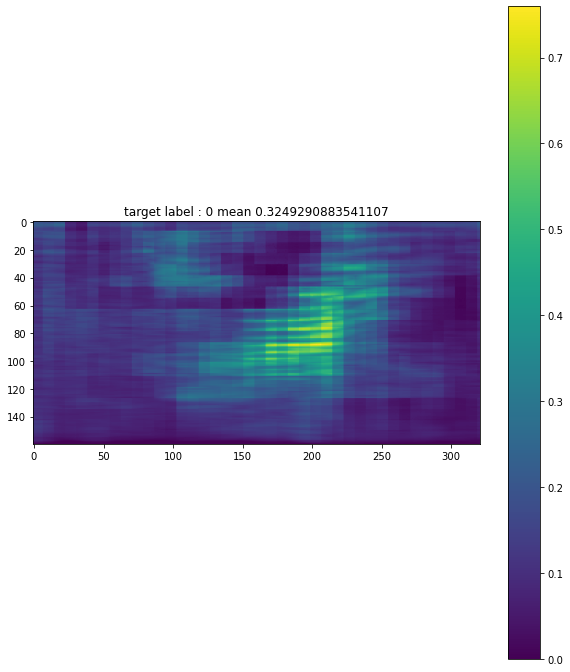

0.1520009


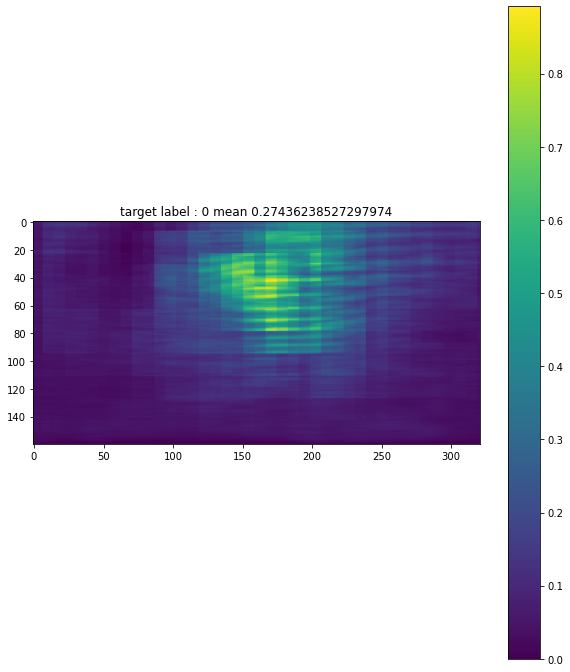

0.19534862


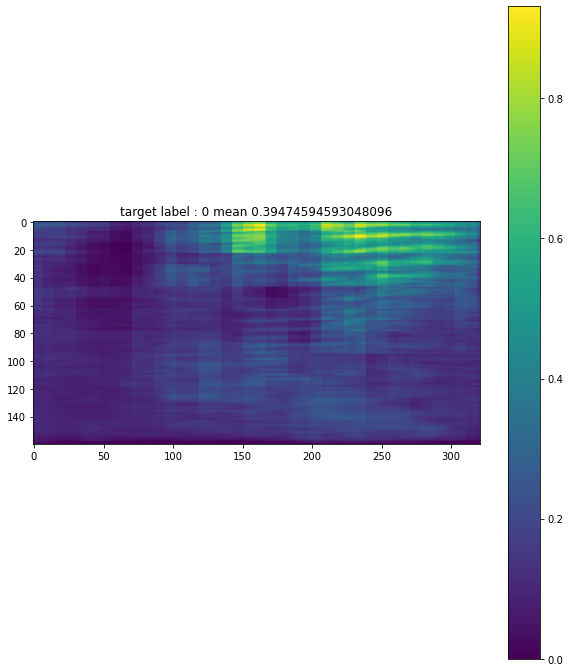

0.2525758


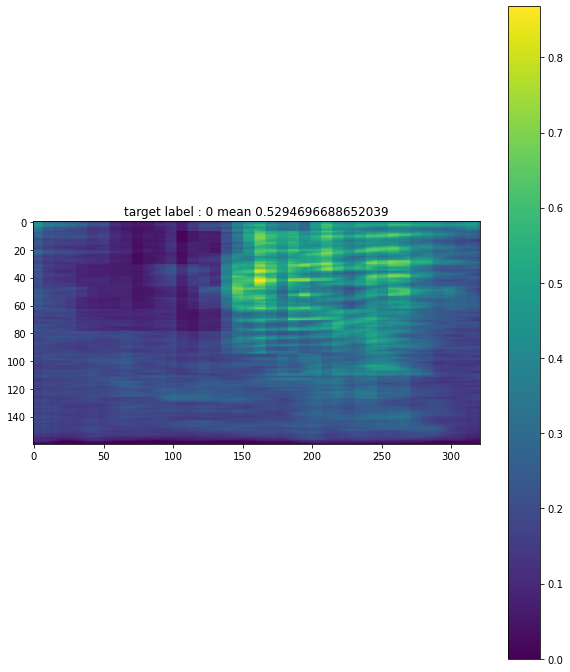

0.16274287


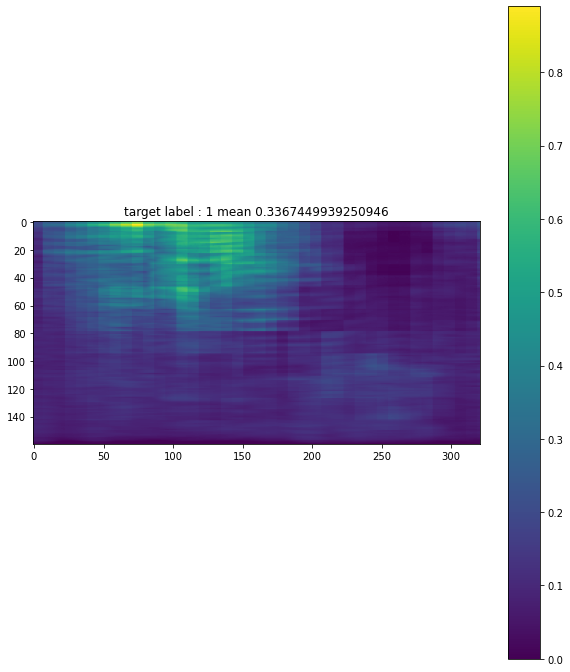

0.16106549


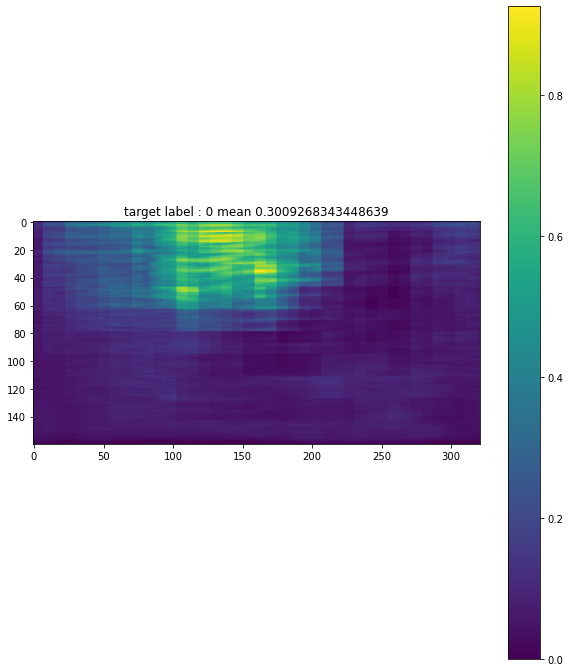

0.17805554


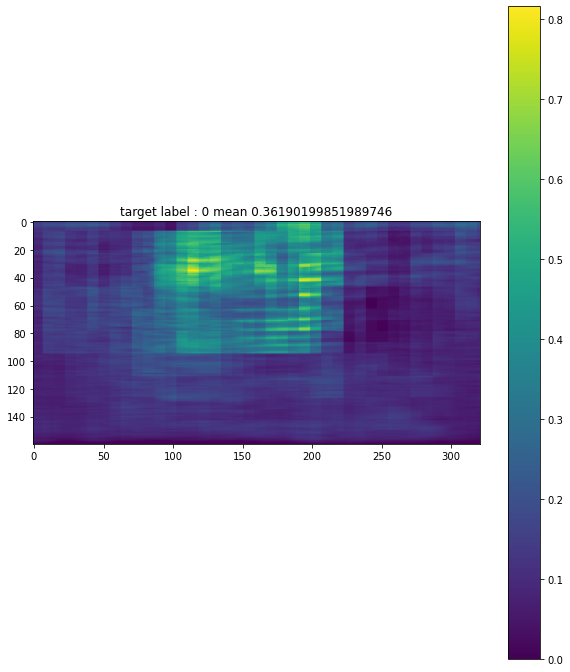

0.1999119


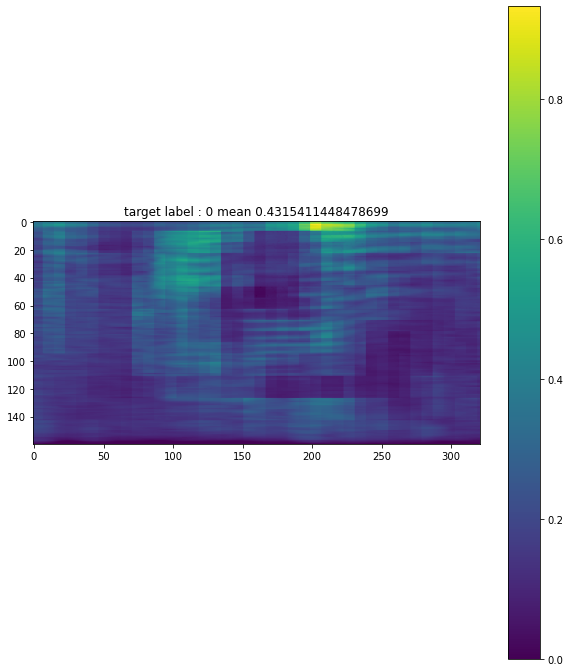

0.19930711


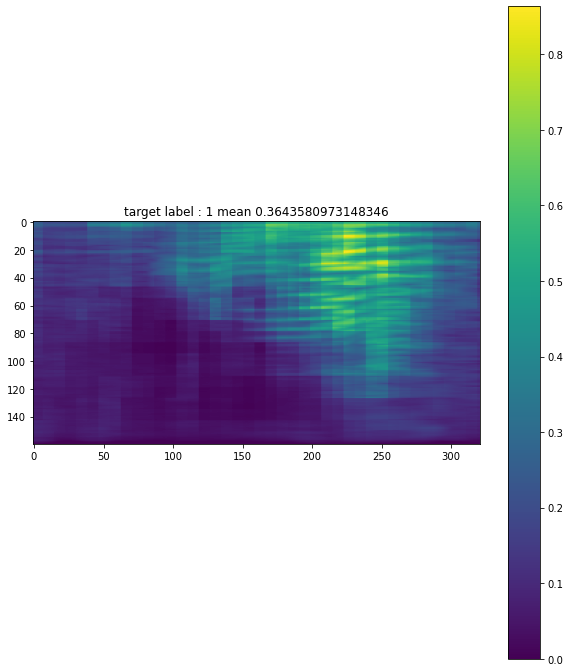

0.1455484


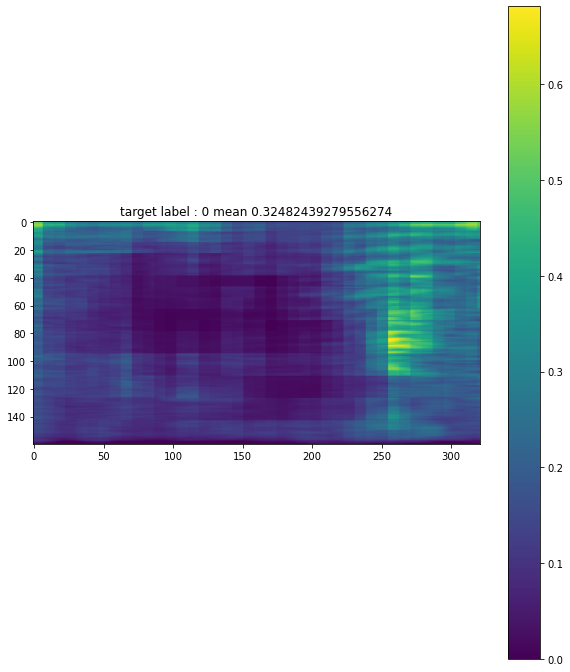

0.17315951


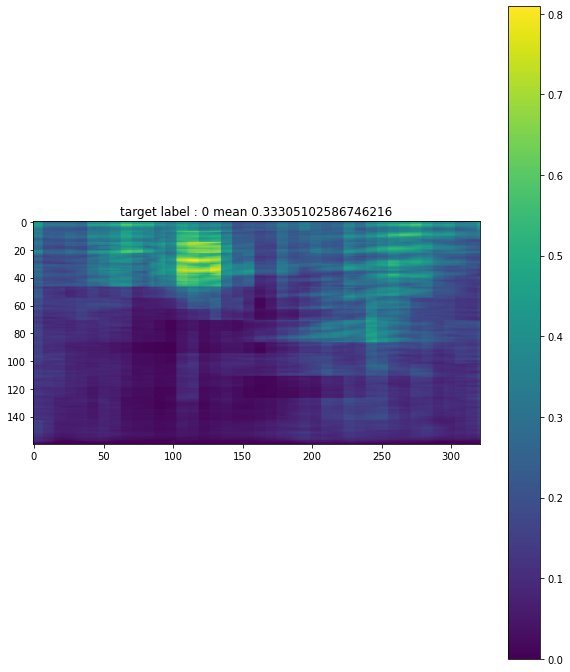

0.19925228


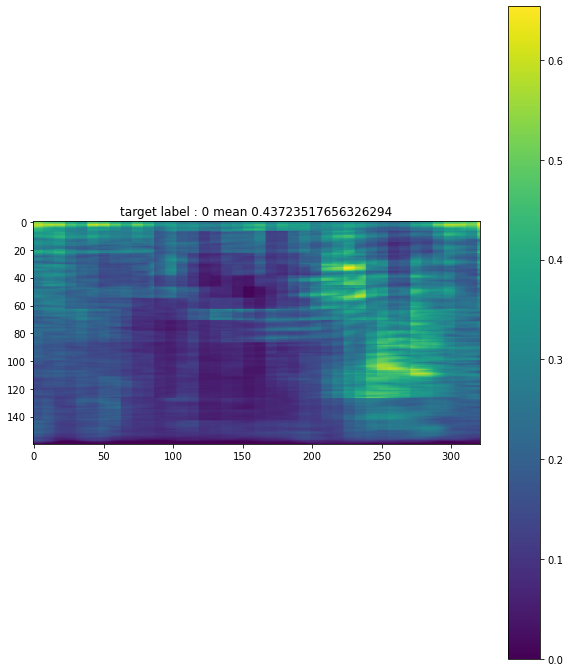

0.23485032


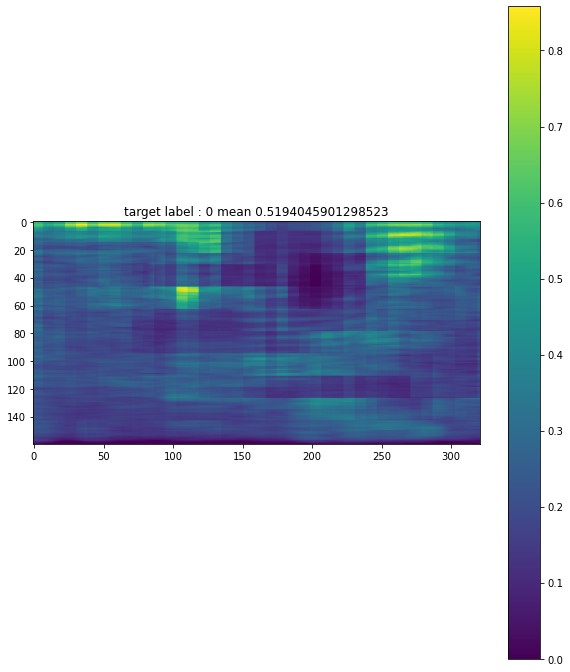

0.14617412


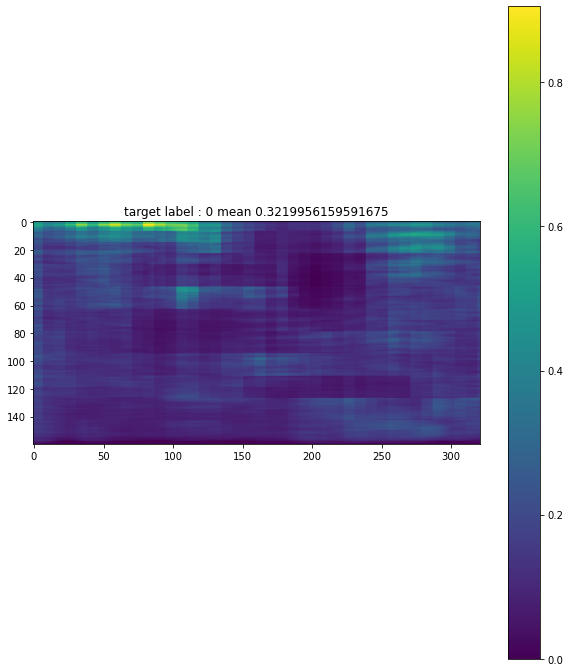

0.15710765


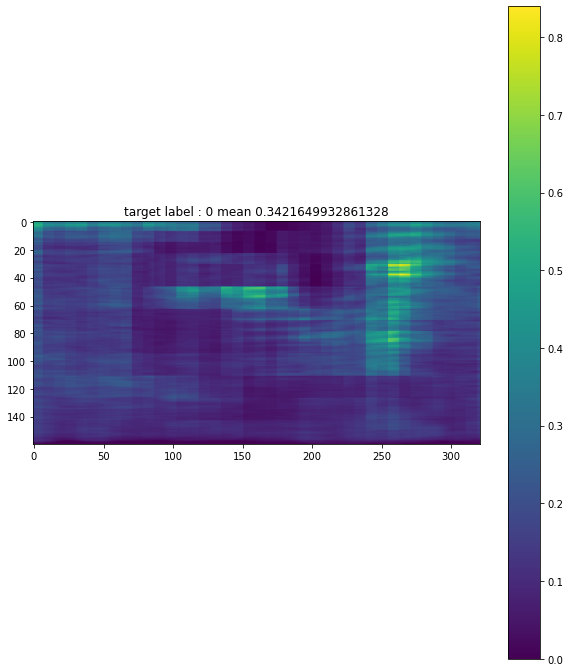

0.17592101


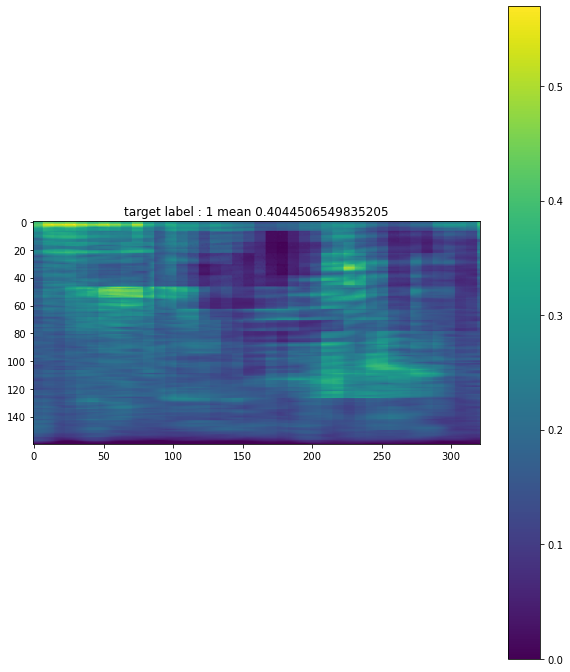

0.17888393


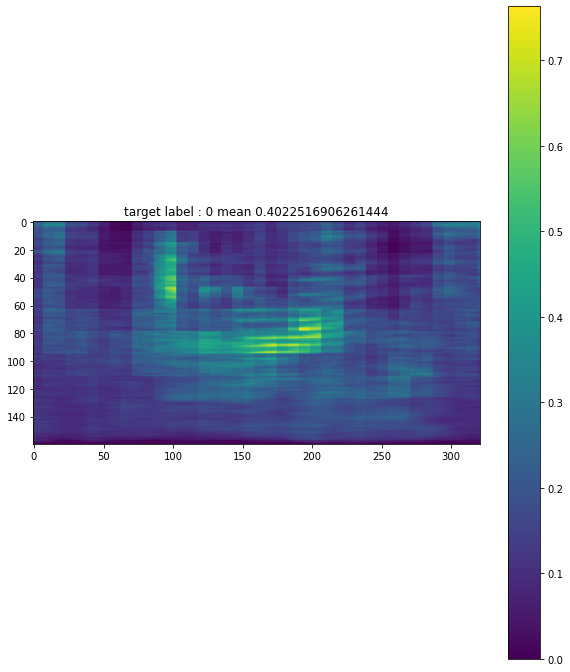

0.19409303


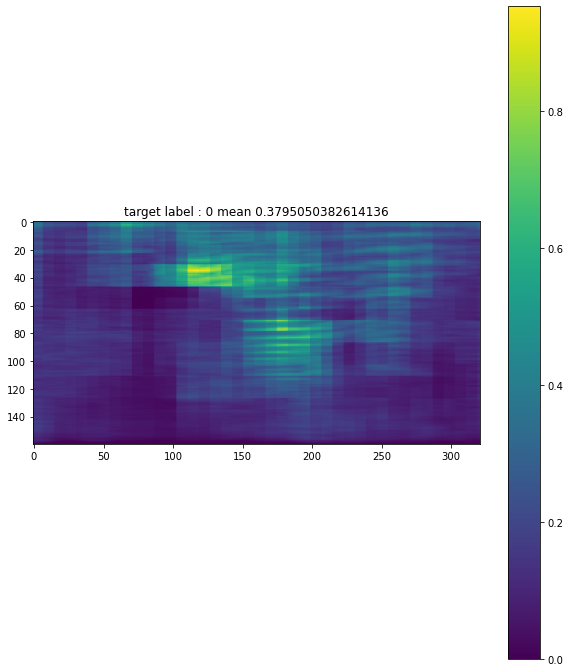

0.17539893


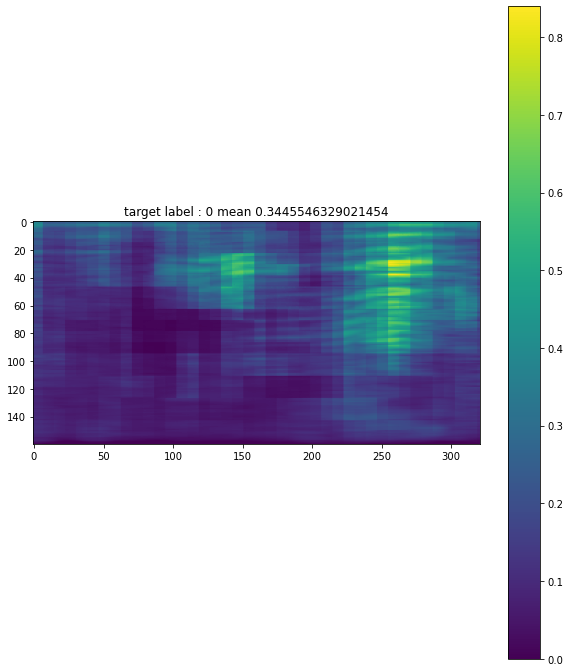

In [63]:
for i in range(31):
    plt.figure(figsize=(10, 12))
    result = np.array(score_softmax[0, i, :, :].cpu())
    
    _max = np.max(result)
    _min = np.min(result)
    norm_result = (result-_min)/(_max-_min)
    plt.title("target label : {} mean {}".format(np.array(target[0, i, 0, 0].cpu()), np.mean(norm_result)))
#     plt.imshow((result-_min)/(_max-_min))
    
    plt.imshow(norm_result*data[0, 0, :, :].cpu().numpy())
    print (np.mean(norm_result*data[0, 0, :, :].cpu().numpy()))
    plt.colorbar()
    plt.show()